# **Hotspot tutorial: Transcriptional Patterns in CD4 T Cells**

In this tutorial, we show how to use the optimized version of the Hotspot algorithm implemented inside Harreman by using one of the datasets used in the [original Hotspot tutorial](https://hotspot.readthedocs.io/en/latest/CD4_Tutorial.html): the public single-cell data from 10x Genomics (*5k Peripheral blood mononuclear cells (PBMCs) from a healthy donor with cell surface proteins (Next GEM)*).
The objective of this tutorial is to show that the PyTorch version of the Hotspot algorithm that has been implemented inside Harreman generates the same results but much faster. For this, the same parameters as in the [original Hotspot tutorial](https://hotspot.readthedocs.io/en/latest/CD4_Tutorial.html) will be used.

In this tutorial we will cover:

1. Data preprocessing and filtering.
2. Computing gene autocorrelation to identify spatial genes.
3. Computing pairwise correlations between genes to group transcriptionally similar genes.
4. Plotting modules, correlations, and module scores.

In [1]:
import harreman
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import mplscience
from scipy.stats import pearsonr, spearmanr, gaussian_kde
import random
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

## Defining the parametric vs non-parametric test function

To compare the results obtained from both the parametric and non-parametric tests, the function below has been defined.

In [2]:
def corr_plot(x, y, mean_expr, max_num=10000, outlier=0.01, line_on=True, method='spearman',
              legend_on=True, size=30, dot_color=None, outlier_color="r",
              alpha=0.8, color_rate=10, corr_on=None, colorbar=True, pmax=95, pmin=5):

    if method == 'pearson':
        score = pearsonr(x, y)
    if method == 'spearman':
        score = spearmanr(x, y)
    np.random.seed(0)
    if len(x) > max_num:
        idx = np.random.permutation(len(x))[:max_num]
        x, y = x[idx], y[idx]
        mean_expr = mean_expr[idx]
    outlier = int(len(x) * outlier)

    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    idx1, idx2 = idx[outlier:], idx[:outlier]

    if dot_color is None:
        c_score = mean_expr
    else:
        c_score = dot_color

    plt.set_cmap("Blues")
    vmax = np.percentile(c_score, pmax)
    vmin = np.percentile(c_score, pmin)
    plt.scatter(x, y, c=c_score, edgecolor=None, s=size, alpha=alpha, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar()

    if line_on:
        clf = linear_model.LinearRegression()
        clf.fit(x.reshape(-1, 1), y)
        xx = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
        yy = clf.predict(xx)
        plt.plot(xx, yy, "k--", label="R=%.3f" % score[0])

    if legend_on or corr_on:
        plt.legend(loc="best", fancybox=True, ncol=1)

## Loading the dataset

In this tutorial, we load the dataset from [this link](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.1.0/5k_pbmc_protein_v3_nextgem). In particular, we will need the `5k_pbmc_protein_v3_filtered_feature_bc_matrix.h5` file.

In [19]:
mdata = mu.read_10x_h5("5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5")

In [20]:
mdata.var_names_make_unique()

In [21]:
adata = mdata.mod["rna"]

In [22]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

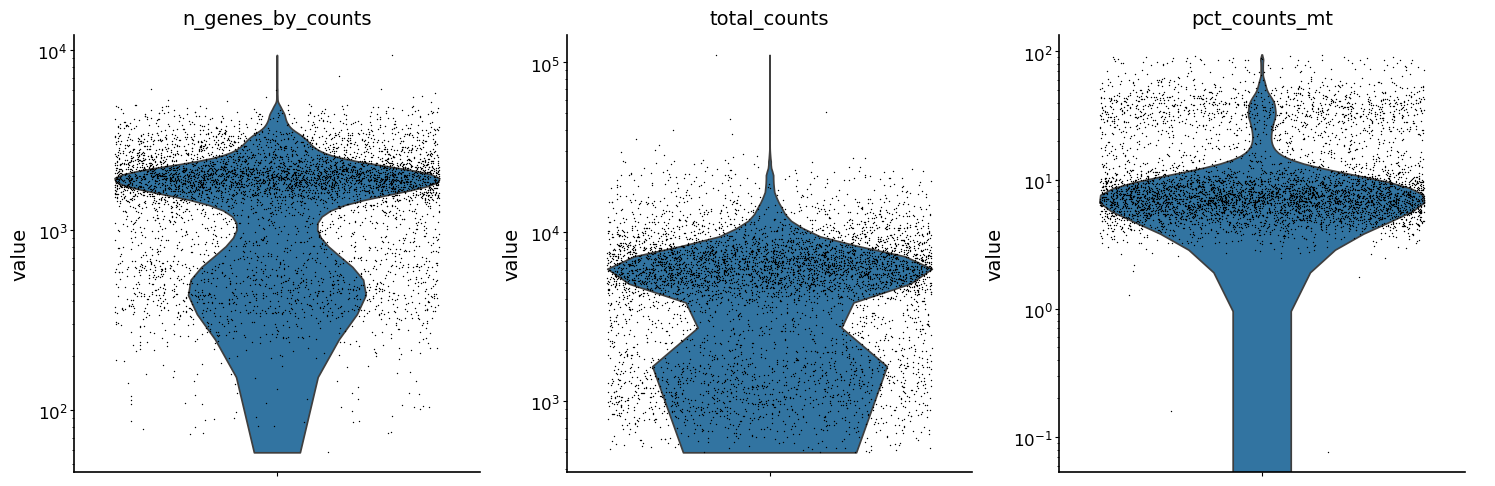

In [23]:
with mplscience.style_context():
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                jitter=0.4, multi_panel=True, log=True)

## Extract the CD4 T cells based on surface protein abundance

In [24]:
from muon import prot as pt
pt.pp.clr(mdata['prot'])

prot_data = mdata.mod["prot"]

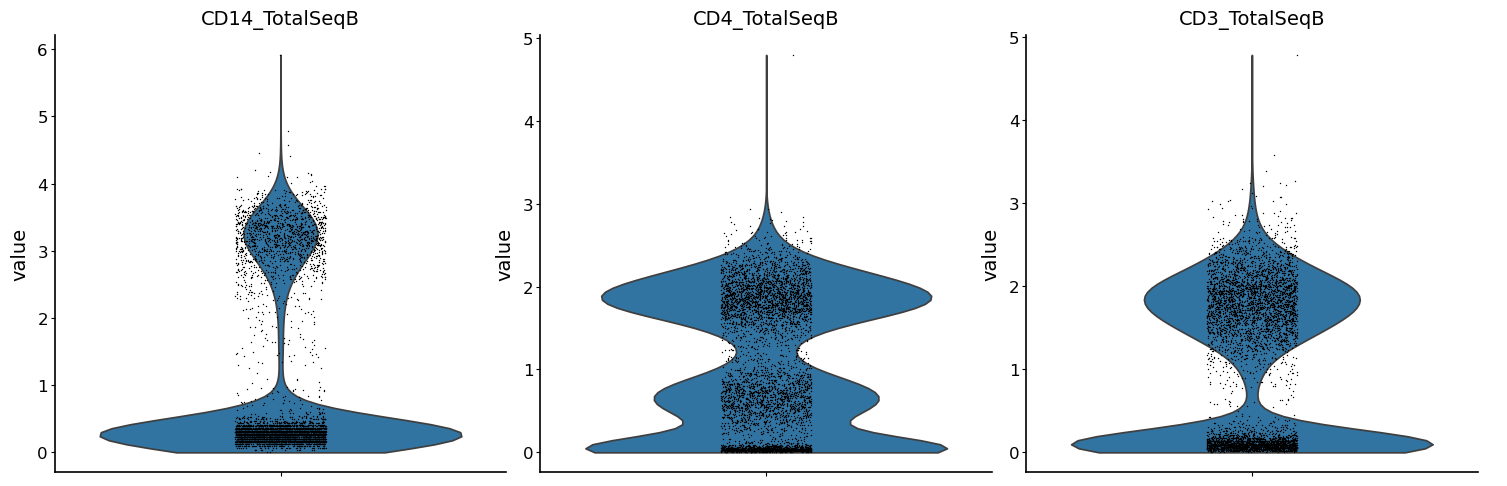

In [25]:
with mplscience.style_context():
    sc.pl.violin(prot_data, keys=["CD14_TotalSeqB", "CD4_TotalSeqB", "CD3_TotalSeqB"], multi_panel=True)

In [26]:
# now create a CD4 T cell mask
is_cd4 = np.asarray(
    (prot_data[:, 'CD14_TotalSeqB'].X.A < 2) &
    (prot_data[:, 'CD4_TotalSeqB'].X.A > 1) &
    (prot_data[:, 'CD3_TotalSeqB'].X.A > 1)
).ravel()

adata_cd4 = adata[is_cd4]
sc.pp.filter_cells(adata_cd4, min_genes=1000)
sc.pp.filter_genes(adata_cd4, min_cells=10)
adata_cd4 = adata_cd4[adata_cd4.obs.pct_counts_mt < 16].copy()

adata_cd4

AnnData object with n_obs × n_vars = 1547 × 12456
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

## Compute a latent space with PCA

In [27]:
adata_cd4.layers["counts"] = adata_cd4.X.copy()
sc.pp.normalize_total(adata_cd4)
sc.pp.log1p(adata_cd4)
adata_cd4.layers["log_normalized"] = adata_cd4.X.copy()
sc.pp.scale(adata_cd4)
sc.tl.pca(adata_cd4)

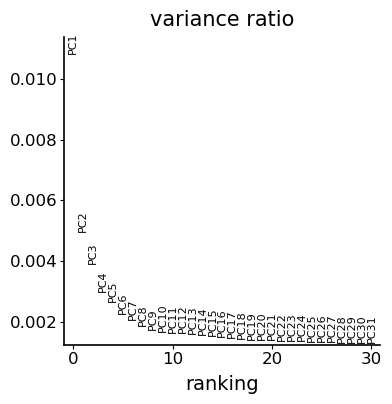

In [28]:
with mplscience.style_context():
    sc.pl.pca_variance_ratio(adata_cd4)

In [29]:
# rerun with fewer components
sc.tl.pca(adata_cd4, n_comps=10)

In [30]:
adata_cd4.layers["counts_csc"] = adata_cd4.layers["counts"].tocsc()

## Computing the proximity graph

Firstly, we compute the neighborhood graph using the `compute_knn_graph` function. For this, we need to specify the latent (or observed) space we are using to compute our cell metric with the `compute_neighbors_on_key` parameter. Further, only one of `compute_neighbors_on_key` or `distances_obsp_key` is needed in order to run the function. Similarly, either the `neighborhood_radius` or the `n_neighbors` parameter needs to be used (the former needs to contain information in micrometers).

Here, we set `weighted_graph=False` to just use binary, 0-1 weights and `n_neighbors=30` to create a local neighborhood in the PCA space with the 30 nearest neighbors for every cell. Larger neighborhood sizes can result in more robust detection of correlations and autocorrelations at a cost of missing more fine-grained, smaller-scale, transcriptional patterns.

In [31]:
harreman.tl.compute_knn_graph(adata_cd4, 
                           compute_neighbors_on_key="X_pca", 
                           n_neighbors=30,
                           weighted_graph=False,
                           verbose=True)

Computing the neighborhood graph...
Computing the weights...
Finished computing the KNN graph in 0.050 seconds


## Computing gene autocorrelation to determine genes with transcriptional variation

Once the neighborhood graph is computed, local autocorrelation needs to be assessed using the `compute_local_autocorrelation` function. For this, we need to specify the gene counts matrix (with the `layer_key` parameter), which background model to use (with the `model` parameter), the per-cell scaling factor (optional, with the `umi_counts_obs_key` parameter), and whether we want to focus on metabolic genes or not (with the `use_metabolic_genes` parameter; False by default). In case we focus on metabolic enzymes, the `species` parameter is used to specify the organism dataset corresponds to. Further, the empirical test can also be run by permutation testing to later compare the results with the theoretical one (with the `permutation_test` parameter).

Here, we are focusing on all genes and we are using the negative binomial distribution to model our count data.

In [32]:
harreman.hs.compute_local_autocorrelation(adata_cd4, layer_key="counts_csc", model='danb', umi_counts_obs_key="total_counts", permutation_test=True)

Permutation test: 100%|██████████| 1000/1000 [00:22<00:00, 44.52it/s]


We visualize the scatter plot to compare the p-values from the theoretical (x-axis) and empirical (y-axis) tests.

Text(0.5, 1.0, 'Autocorrelation p-value (Permutation vs Z-Score)')

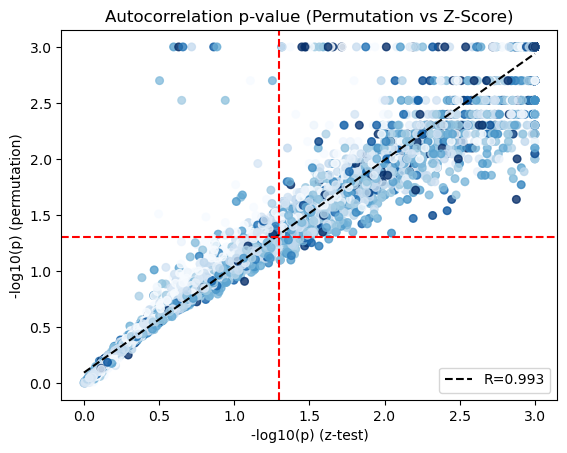

In [33]:
x = -np.log10(adata_cd4.uns['gene_autocorrelation_results'].Z_Pval.values)
y = -np.log10(adata_cd4.uns['gene_autocorrelation_results'].Perm_Pval.values)

genes = adata_cd4.uns['gene_autocorrelation_results'].index

X = adata_cd4[:,genes].layers['log_normalized'].tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Autocorrelation p-value (Permutation vs Z-Score)')

We only use the top 500 genes (sorted by their Z-score) with a significant autocorrelation (FDR < 0.05) for the subsequent analysis.

In [36]:
hs_results = adata_cd4.uns['gene_autocorrelation_results']
hs_genes = hs_results.loc[hs_results.Z_FDR < 0.05].sort_values('Z', ascending=False).head(500).index

## Computing local correlation to group genes into spatial modules

To get a better idea of what spatial patterns exist, it is helpful to group the genes into modules. This is done by using the concept of *local correlations* - that is, correlations that are computed between genes between cells in the same neighborhood.

Here, we avoid running the calculation for all Genes x Genes pairs and instead only run this on genes that have significant spatial autocorrelation to begin with.

The `compute_local_correlation` function returns a Genes x Genes matrix of Z-scores for the significance of the correlation between genes. This object is retained in the AnnData object and is used in the subsequent steps.

Here, the empirical test can also be run by permutation testing to later compare the results with the theoretical one (with the `permutation_test` parameter).

In [37]:
harreman.hs.compute_local_correlation(adata_cd4, genes=hs_genes, permutation_test=True, verbose=True)

Computing pair-wise local correlation on 500 features...


Permutation test:   0%|          | 0/1000 [00:00<?, ?it/s]

Permutation test: 100%|██████████| 1000/1000 [00:06<00:00, 156.02it/s]

Pair-wise local correlation results are stored in adata.uns with the following keys: ['lc_perm_pvals', 'lc_perm_pvals_sym', 'lcs', 'lc_zs', 'lc_z_pvals', 'lc_z_FDR']
Finished computing pair-wise local correlation in 6.520 seconds


We visualize the scatter plot to compare the p-values from the theoretical (x-axis) and empirical (y-axis) tests.

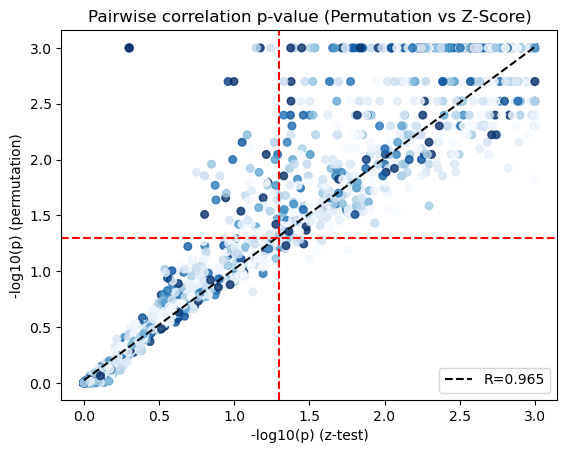

In [39]:
x = -np.log10(adata_cd4.uns['lc_z_pvals'].values).flatten()
y = -np.log10(adata_cd4.uns['lc_perm_pvals'].values).flatten()

genes = adata_cd4.uns['lc_z_pvals'].index

X = adata_cd4[:,genes].layers['log_normalized'].tocsc()  # make sure it's column-compressed for efficient slicing
sums = X.sum(axis=0).A1
counts = (X > 0).sum(axis=0).A1
mean_expr = sums / counts

mean_expr_matrix = (mean_expr[:, np.newaxis] + mean_expr[np.newaxis, :]) / 2
mean_expr_values = mean_expr_matrix.flatten()
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
corr_plot(x, y, mean_expr_values, method='spearman', colorbar=False, pmin=10, pmax=90)
plt.axhline(-np.log10(0.05), color='r', linestyle='--')
plt.axvline(-np.log10(0.05), color='r', linestyle='--')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Pairwise correlation p-value (Permutation vs Z-Score)')

Now that pairwise local correlations are calculated, we can group genes into modules.

To do this, the `create_modules` function is used, which performs agglomerative clustering with two caveats:

1. If the FDR-adjusted p-value of the correlation between two branches exceeds `fdr_threshold`, then the branches are not merged.

2. If two branches are to be merged and they both have at least `min_gene_threshold` genes, then the branches are not merged. Further genes that would join to the resulting merged module (and are therefore ambiguous) either remain unassigned (if `core_only=True`) or are assigned to the module with the smaller average correlations between genes, i.e. the least-dense module (if `core_only=False`). Unassigned genes are indicated with a module number of -1.

In [40]:
harreman.hs.create_modules(adata_cd4, min_gene_threshold=15, core_only=True, fdr_threshold=0.05)

## Plotting module correlations

We then can visualize the created modules.

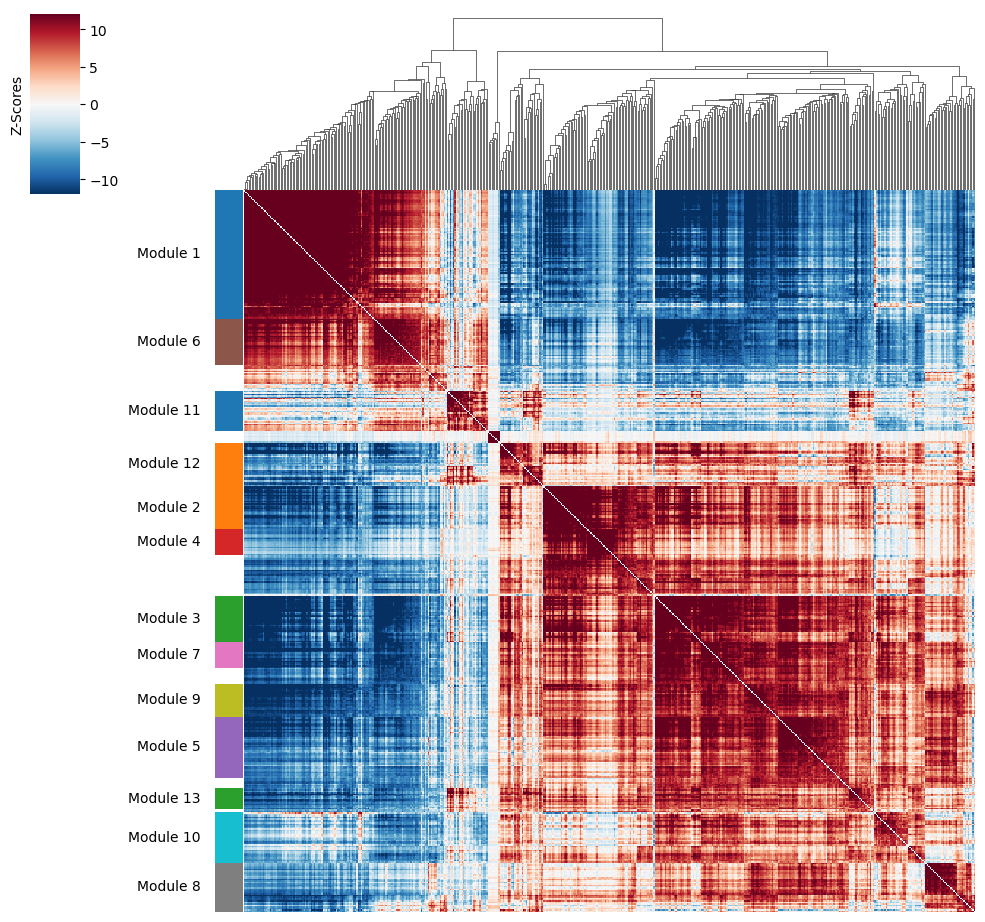

In [41]:
harreman.pl.local_correlation_plot(adata_cd4, vmin=-12, vmax=12)

## Calculating module scores and visualizing them

To characterize the general behavior of a module, module scores are computed.

In [42]:
harreman.hs.calculate_module_scores(adata_cd4)

100%|██████████| 13/13 [00:00<00:00, 35.99it/s]


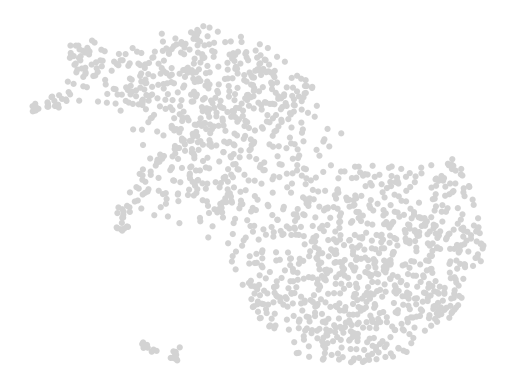

In [43]:
sc.pp.neighbors(adata_cd4)
sc.tl.umap(adata_cd4)
sc.pl.umap(adata_cd4, frameon=False)

In [44]:
modules = adata_cd4.obsm['module_scores'].columns
adata_cd4.obs[modules] = adata_cd4.obsm['module_scores']

Finally, we visualize the module scores on top of the UMAP for comparison.

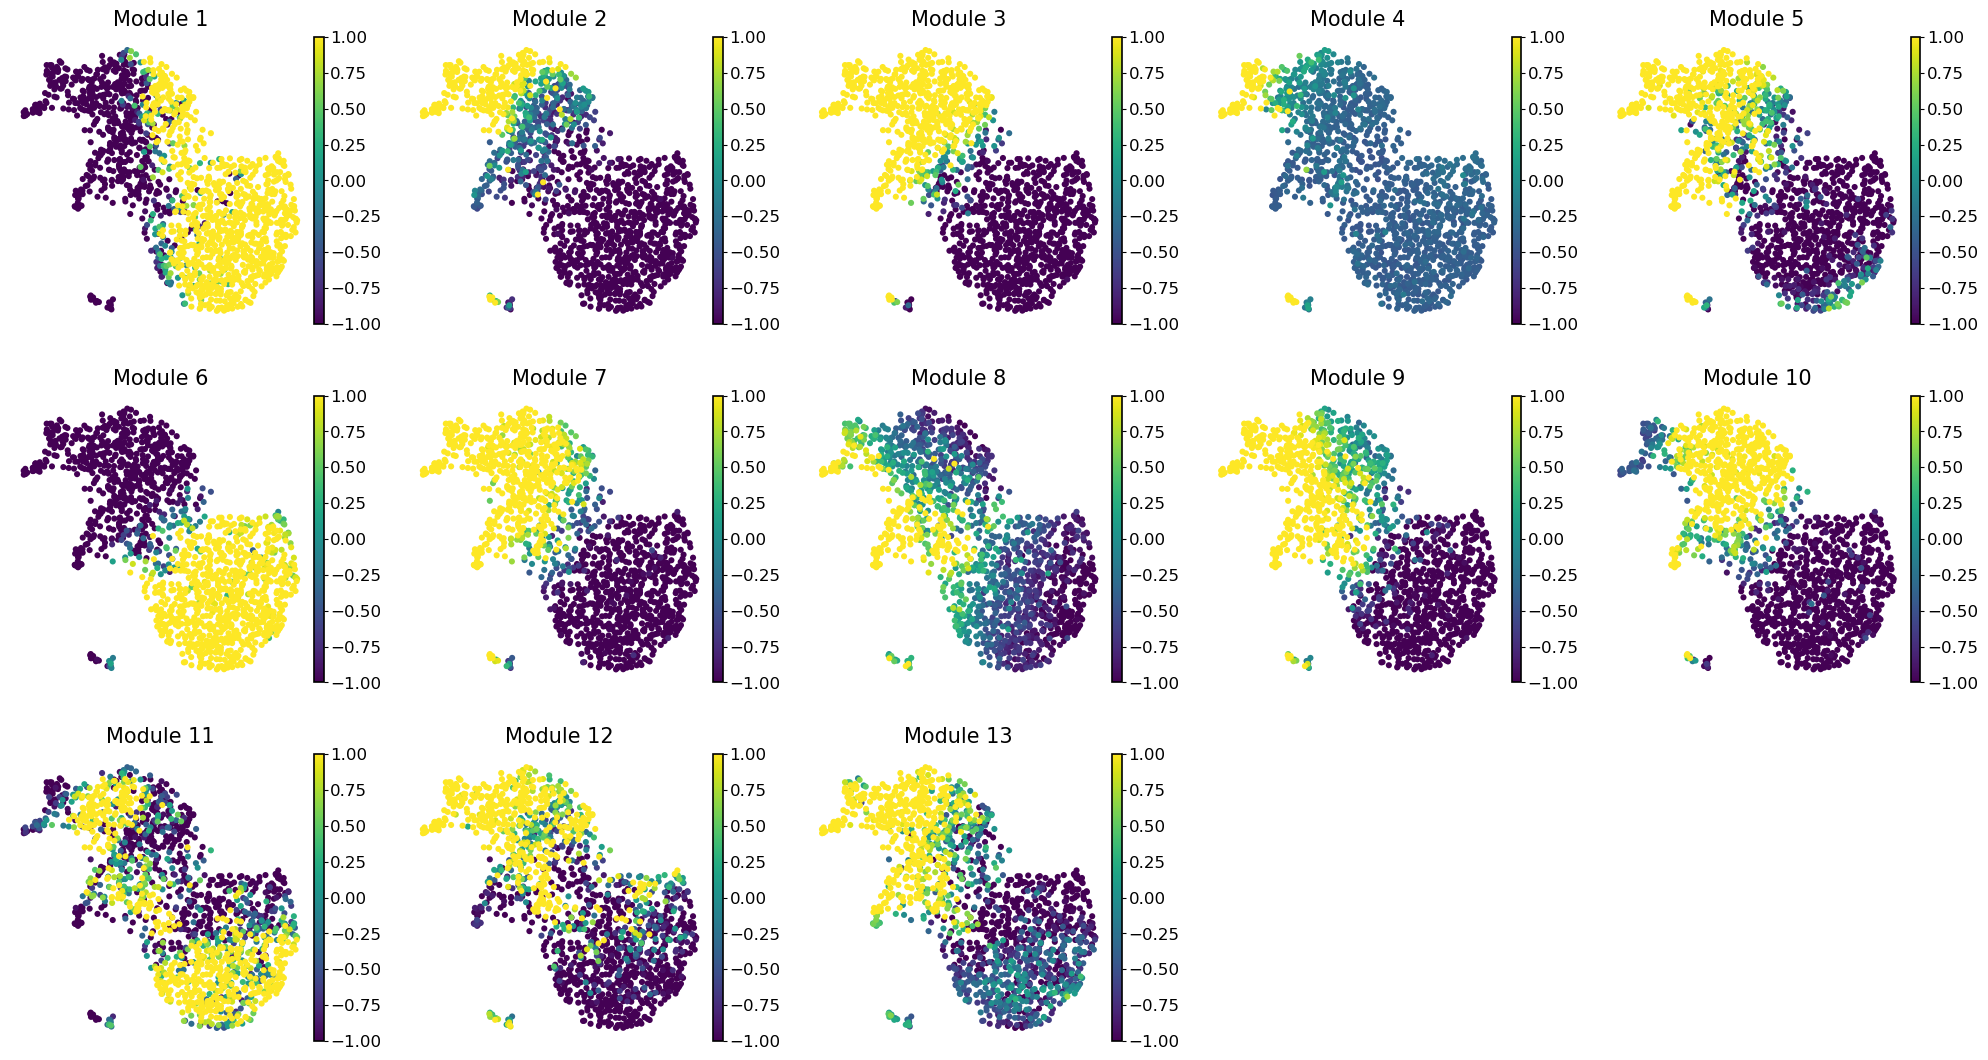

In [46]:
with mplscience.style_context():
    sc.pl.umap(adata_cd4, color=modules, frameon=False, vmin="-1", vmax="1", ncols=5, cmap='viridis')